In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import data

In [2]:
conn = sqlite3.connect('european_database.sqlite')

In [3]:
matches = pd.read_sql('SELECT * FROM matchs', conn)
divisions = pd.read_sql('SELECT * FROM divisions', conn)

In [ ]:
matches.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season
306,D1,2020-09-18,Bayern Munich,Schalke 04,8.0,0.0,H,2021
307,D1,2020-09-19,Ein Frankfurt,Bielefeld,1.0,1.0,D,2021
308,D1,2020-09-19,FC Koln,Hoffenheim,2.0,3.0,A,2021
309,D1,2020-09-19,Stuttgart,Freiburg,2.0,3.0,A,2021
310,D1,2020-09-19,Union Berlin,Augsburg,1.0,3.0,A,2021


In [ ]:
divisions

,division,name,country
0,B1,Division 1A,Belgium
1,D1,Bundesliga,Deutschland
2,D2,2. Bundesliga,Deutschland
3,E0,Premier League,England
4,E1,EFL Championship,England
5,E2,EFL League One,England
6,E3,EFL League Two,England
7,EC,National League,England
8,F1,Ligue 1,France
9,F2,Ligue 2,France


Filter unwanted records

In [4]:
# drop unnecessary leagues
hold_list = ['D1', 'E0', 'F1', 'I1', 'N1', 'SP1']
divisions = divisions.query('division in @hold_list')
divisions.reset_index(drop=True, inplace=True)
divisions

,division,name,country
0,D1,Bundesliga,Deutschland
1,E0,Premier League,England
2,F1,Ligue 1,France
3,I1,Seria A,Italy
4,N1,Eredivisie,Netherlands
5,SP1,LaLiga,Spain


In [5]:
matches = matches.query('Div in @hold_list')
matches.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season
306,D1,2020-09-18,Bayern Munich,Schalke 04,8.0,0.0,H,2021
307,D1,2020-09-19,Ein Frankfurt,Bielefeld,1.0,1.0,D,2021
308,D1,2020-09-19,FC Koln,Hoffenheim,2.0,3.0,A,2021
309,D1,2020-09-19,Stuttgart,Freiburg,2.0,3.0,A,2021
310,D1,2020-09-19,Union Berlin,Augsburg,1.0,3.0,A,2021


In [ ]:
print(matches.shape)
print(divisions.shape) # examine shape

(33937, 8)
(6, 3)


In [ ]:
# backup dataset
matches_backup = matches.copy(deep=True)
divisions_backup = divisions.copy(deep=True)
# matchs = matchs_backup.copy(deep=True)
# divisions = divisions_backup.copy(deep=True)

Data Checking

In [ ]:
matches.isna().sum()

Div         0
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
season      0
dtype: int64

In [ ]:
dup = matches[['Div', 'season']].duplicated()
div_season = matches[['Div', 'season']][~dup]
for d in divisions['division']:
    print('{:<5}'.format(d), end=' | ')
    seasons = set(div_season.query('Div == @d')['season'])
    print(seasons) # all leagues have been recorded in the given period from 2006 to 2021 season

D1    | {2016, 2017, 2018, 2019, 2020, 2021, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}
E0    | {2016, 2017, 2018, 2019, 2020, 2021, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}
F1    | {2016, 2017, 2018, 2019, 2020, 2021, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}
I1    | {2016, 2017, 2018, 2019, 2020, 2021, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}
N1    | {2016, 2017, 2018, 2019, 2020, 2021, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}
SP1   | {2016, 2017, 2018, 2019, 2020, 2021, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}


Create another referenced table

In [6]:
div_season_match_team = matches.groupby(['Div', 'season']).count()
div_season_match_team = div_season_match_team[['FTHG', 'FTAG']] # take 2 arbitary columns

rename_dict = {'FTHG': 'No of Matches', 'FTAG': 'No of Teams'}
div_season_match_team.rename(columns=rename_dict, inplace=True)
# apply function
div_season_match_team['No of Teams'] = \
    div_season_match_team['No of Teams'].apply(lambda x: np.ceil(np.sqrt(x)))
div_season_match_team

No of Matches  No of Teams
Div season                            
D1  2006              306         18.0
    2007              306         18.0
    2008              306         18.0
    2009              306         18.0
    2010              306         18.0
...                   ...          ...
SP1 2017              380         20.0
    2018              380         20.0
    2019              380         20.0
    2020              380         20.0
    2021              380         20.0

[96 rows x 2 columns]

In [ ]:
div_season_match_team.groupby('Div')['No of Teams'].nunique() # abnormal detection

Div
D1     1
E0     1
F1     2
I1     1
N1     2
SP1    1
Name: No of Teams, dtype: int64

In [ ]:
# create a similar table use another way
div_season_team = matches.groupby(['Div', 'season'])['HomeTeam'].nunique()
# merge 2 fields having same meaning
merge_frame = pd.merge(div_season_match_team, div_season_team, how='inner', left_index=True, right_index=True)
# compare
merge_frame[merge_frame['No of Teams'] != merge_frame['HomeTeam']]

No of Matches  No of Teams  HomeTeam
Div season                                      
F1  2020              279         17.0        20
N1  2011              306         18.0        27
    2020              232         16.0        18

In [ ]:
N1_2011 = matches.query('Div == "N1" and season == 2011')
set(N1_2011['HomeTeam']) # trailing spaces occur
len(set(N1_2011['HomeTeam'].apply(lambda x: x.strip()))) # is 18, correct!

18

In [7]:
# clean the name columns
matches['HomeTeam'] = matches['HomeTeam'].apply(lambda x: x.strip())
matches['AwayTeam'] = matches['AwayTeam'].apply(lambda x: x.strip())
# correcting stats table
div_season_match_team.loc['F1'].loc[2020, 'No of Teams'] = 20.0
div_season_match_team.loc['N1'].loc[2020, 'No of Teams'] = 18.0

In [10]:
# get the number of matches per round
def matches_per_round(division, season):
    n = div_season_match_team.loc[division].loc[season]['No of Teams']
    n = int(n / 2)
    return n

In [11]:
# get the number of rounds of league
def max_round(division, season):
    n = matches_per_round(division, season)
    m = div_season_match_team.loc[division].loc[season]['No of Matches']
    num = int(np.ceil(m / n))
    return num

In [12]:
matches['Date'] = pd.to_datetime(matches['Date'])

In [ ]:
matches_backup = matches.copy(deep=True)
divisions_backup = divisions.copy(deep=True)

# Create more tables for variety queries

Dynamic result tables

In [ ]:
# create one hot frame for result column
def result_onehot(frame):
    onehot = OneHotEncoder(sparse_output=False)
    # get the categorical column in suitable form
    ftr = frame['FTR'].tolist()
    ftr = np.array(ftr)
    ftr = ftr.reshape(len(ftr), 1)
    # apply
    onehot = onehot.fit(ftr)
    columns = onehot.categories_
    onehot = onehot.fit_transform(ftr)
    output = pd.DataFrame(onehot, index=frame['FTR'].index, columns=columns)
    return output

In [ ]:
# convert a frame of matches to result table
def matches_to_table(frame):
    '''
    each match affects 2 teams
    each point in FTHG is a goal for home team and obviously a goal aganst home team
    FTAG is similar
    H in FTR means home team is the winner, A for away team
    '''
    # home frame for home team
    home = frame[['HomeTeam', 'FTHG', 'FTAG', 'FTR']].copy(deep=True)
    home.rename(columns={'HomeTeam': 'Team', 'FTHG': 'GF', 'FTAG': 'GA'}, inplace=True)
    # away frame for away team
    away = frame[['AwayTeam', 'FTAG', 'FTHG', 'FTR']].copy(deep=True)
    away.rename(columns={'AwayTeam': 'Team', 'FTAG': 'GF', 'FTHG': 'GA'}, inplace=True)
    away['FTR'].replace({'H': 'A', 'A': 'H'}, inplace=True)

    output = pd.concat([home, away], ignore_index=True)
    result = result_onehot(output) # retrieve 3 new columns from original FTR
    if result.shape[1] != 3:
        full_columns = [('A',), ('D',), ('H,')]
        for c in full_columns:
            if c not in result.columns:
                result[c] = 0
    output = pd.concat([output, result], axis=1) # expand frame
    # group all stats for each team
    output1 = output.drop('FTR', axis=1)
    output1 = output1.groupby('Team').sum()
    # get the number of matchs of each team
    output2 = output.groupby('Team')['GF'].count()
    # merge columns in one stats table and manipulate the output
    output = pd.merge(output2, output1, how='inner', left_index=True, right_index=True)
    output.rename(columns={'GF_x': 'Played', 'GF_y': 'GF', ('A',): 'Lost', ('D',): 'Drawn', ('H',): 'Won'}, inplace=True)
    output = output[['Played', 'Won', 'Drawn', 'Lost', 'GF', 'GA']]
    return output

In [ ]:
# retrieve all match results in a given time range
def matches_between(division, begin, end):
    # string to datetime
    begin = pd.to_datetime(begin)
    end = pd.to_datetime(end)
    # query frame by parameters and do some manipulations
    frame = matches.query('Div == @division and Date >= @begin and Date <= @end').copy(deep=True)
    frame.drop(['Div'], axis=1, inplace=True) # don't need this column 'cause the context is known
    frame.sort_values(by=['Date'], inplace=True)
    return frame

In [ ]:
# retrieve team results in a given time range
def league_result_between(division, begin, end):
    frame = matches_between(division, begin, end)
    frame = matches_to_table(frame)
    return frame

In [ ]:
# compare 2 results
matches_between('E0', '20050813', '20050823')

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season
116536,2005-08-13,Aston Villa,Bolton,2.0,2.0,D,2006
116537,2005-08-13,Everton,Man United,0.0,2.0,A,2006
116538,2005-08-13,Fulham,Birmingham,0.0,0.0,D,2006
116539,2005-08-13,Man City,West Brom,0.0,0.0,D,2006
116540,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D,2006
116541,2005-08-13,Portsmouth,Tottenham,0.0,2.0,A,2006
116542,2005-08-13,Sunderland,Charlton,1.0,3.0,A,2006
116543,2005-08-13,West Ham,Blackburn,3.0,1.0,H,2006
116544,2005-08-14,Arsenal,Newcastle,2.0,0.0,H,2006
116545,2005-08-14,Wigan,Chelsea,0.0,1.0,A,2006


In [ ]:
league_result_between('E0', '20050813', '20050823')

,Played,Won,Drawn,Lost,GF,GA
Team,,,,,,
Arsenal,2,1.0,0.0,1.0,2.0,1.0
Aston Villa,3,0.0,2.0,1.0,3.0,4.0
Birmingham,3,0.0,1.0,2.0,1.0,5.0
Blackburn,2,1.0,0.0,1.0,3.0,4.0
Bolton,2,0.0,1.0,1.0,2.0,3.0
Charlton,2,2.0,0.0,0.0,4.0,1.0
Chelsea,2,2.0,0.0,0.0,2.0,0.0
Everton,2,1.0,0.0,1.0,1.0,2.0
Fulham,2,0.0,1.0,1.0,1.0,2.0


In [ ]:
# query in the round version

# retrieve all match results in a given round
def matches_in_round(division, season, round):
    # query frame by parameters and do some manipulations
    frame = matches.query('Div == @division').copy(deep=True)
    frame = frame[frame['season']==season]
    frame.drop(['Div', 'season'], axis=1, inplace=True)
    frame.sort_values(by=['Date'], inplace=True)
    # query by round
    n = matches_per_round(division, season)
    begin = n * (round - 1)
    end = n * round
    try:
        x = frame.iloc[begin:end]
    except TypeError:
        return 'Invalid Round!'
    else:
        frame = frame.iloc[begin:end]
        return frame

In [ ]:
# test
matches_in_round('E0', 2007, 2)
# matches_in_round('E0', 2006, 3.1)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
108737,2006-08-22,Watford,West Ham,1.0,1.0,D
108736,2006-08-22,Tottenham,Sheffield United,2.0,0.0,H
108738,2006-08-23,Aston Villa,Reading,2.0,1.0,H
108739,2006-08-23,Blackburn,Everton,1.0,1.0,D
108740,2006-08-23,Charlton,Man United,0.0,3.0,A
108741,2006-08-23,Fulham,Bolton,1.0,1.0,D
108742,2006-08-23,Man City,Portsmouth,0.0,0.0,D
108743,2006-08-23,Middlesbrough,Chelsea,2.0,1.0,H
108750,2006-08-26,Wigan,Reading,1.0,0.0,H
108749,2006-08-26,Watford,Man United,1.0,2.0,A


In [ ]:
# seasonal result is just the cumulation of results from the 1st match

# retrieve all match results after a given round
def matches_after_round(division, season, round):
    # query frame by parameters and do some manipulations
    frame = matches.query('Div == @division').copy(deep=True)
    frame = frame[frame['season']==season]
    frame.drop(['Div', 'season'], axis=1, inplace=True)
    frame.sort_values(by=['Date'], inplace=True)
    # query by round
    n = matches_per_round(division, season)
    end = n * round
    try:
        frame.iloc[:end]
    except TypeError:
        return 'Invalid Round!'
    else:
        frame = frame.iloc[:end]
    return frame

In [ ]:
# test
matches_after_round('E0', 2006, 3)
# matches_after_round('SP1', 2007, 2)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
116536,2005-08-13,Aston Villa,Bolton,2.0,2.0,D
116537,2005-08-13,Everton,Man United,0.0,2.0,A
116538,2005-08-13,Fulham,Birmingham,0.0,0.0,D
116539,2005-08-13,Man City,West Brom,0.0,0.0,D
116540,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D
116541,2005-08-13,Portsmouth,Tottenham,0.0,2.0,A
116542,2005-08-13,Sunderland,Charlton,1.0,3.0,A
116543,2005-08-13,West Ham,Blackburn,3.0,1.0,H
116544,2005-08-14,Arsenal,Newcastle,2.0,0.0,H
116545,2005-08-14,Wigan,Chelsea,0.0,1.0,A


In [ ]:
# retrieve team results after a given round
def league_result_after_round(division, season, round):
    frame = matches_after_round(division, season, round)
    if isinstance(frame, str):
        n = 2 # pass
    else:
        frame = matches_to_table(frame)
        # expand frame
        frame['GD'] = frame['GF'] - frame['GA']
        frame['Points'] = frame['Won'] * 3 + frame['Drawn']
        # sorting
        frame.sort_values(by=['Points', 'GD', 'Team'], ascending=False, inplace=True)
        frame.reset_index(drop=False, inplace=True)
        frame['Rank'] = frame.index + 1
        frame.set_index('Team', inplace=True)
    return frame

In [ ]:
# test
league_result_after_round('E0', 2006, 3)
# league_result_after_roundd('SP1', 2007, 2)

,Played,Won,Drawn,Lost,GF,GA,GD,Points,Rank
Team,,,,,,,,,
Chelsea,4,4.0,0.0,0.0,8.0,0.0,8.0,12.0,1
Man City,4,3.0,1.0,0.0,6.0,3.0,3.0,10.0,2
Tottenham,4,2.0,1.0,1.0,4.0,2.0,2.0,7.0,3
Arsenal,3,2.0,0.0,1.0,6.0,2.0,4.0,6.0,4
Man United,2,2.0,0.0,0.0,3.0,0.0,3.0,6.0,5
Charlton,2,2.0,0.0,0.0,4.0,1.0,3.0,6.0,6
Aston Villa,4,1.0,2.0,1.0,4.0,4.0,0.0,5.0,7
West Ham,2,1.0,1.0,0.0,3.0,1.0,2.0,4.0,8
Middlesbrough,3,1.0,1.0,1.0,3.0,2.0,1.0,4.0,9


In [ ]:
def league_result_season(division, season):
    round = max_round(division, season)
    frame = league_result_after_round(division, season, round)
    return frame

In [ ]:
# test
league_result_season('E0', 2006) # compare to wikipedia's information

,Played,Won,Drawn,Lost,GF,GA,GD,Points,Rank
Team,,,,,,,,,
Chelsea,38,29.0,4.0,5.0,72.0,22.0,50.0,91.0,1
Man United,38,25.0,8.0,5.0,72.0,34.0,38.0,83.0,2
Liverpool,38,25.0,7.0,6.0,57.0,25.0,32.0,82.0,3
Arsenal,38,20.0,7.0,11.0,68.0,31.0,37.0,67.0,4
Tottenham,38,18.0,11.0,9.0,53.0,38.0,15.0,65.0,5
Blackburn,38,19.0,6.0,13.0,51.0,42.0,9.0,63.0,6
Newcastle,38,17.0,7.0,14.0,47.0,42.0,5.0,58.0,7
Bolton,38,15.0,11.0,12.0,49.0,41.0,8.0,56.0,8
West Ham,38,16.0,7.0,15.0,52.0,55.0,-3.0,55.0,9


In [ ]:
# validate covid season
league_result_after_round('F1', 2020, 27)
league_result_after_round('F1', 2020, 28)
league_result_season('F1', 2020)

,Played,Won,Drawn,Lost,GF,GA,GD,Points,Rank
Team,,,,,,,,,
Paris SG,27,22.0,2.0,3.0,75.0,24.0,51.0,68.0,1
Marseille,28,16.0,8.0,4.0,41.0,29.0,12.0,56.0,2
Rennes,28,15.0,5.0,8.0,38.0,24.0,14.0,50.0,3
Lille,28,15.0,4.0,9.0,35.0,27.0,8.0,49.0,4
Reims,28,10.0,11.0,7.0,26.0,21.0,5.0,41.0,5
Nice,28,11.0,8.0,9.0,41.0,38.0,3.0,41.0,6
Lyon,28,11.0,7.0,10.0,42.0,27.0,15.0,40.0,7
Montpellier,28,11.0,7.0,10.0,35.0,34.0,1.0,40.0,8
Monaco,28,11.0,7.0,10.0,44.0,44.0,0.0,40.0,9


Performance report by ranking

In [ ]:
# ranking variation of a team in given season
def team_performance(team, season):
    # calculate
    division = matches.query('HomeTeam == @team').iloc[0]['Div']
    maxround = max_round(division, season)
    # query values
    ranks = []
    for i in range(maxround):
        round = i + 1
        rank = league_result_after_round(division, season, round).loc[team]['Rank'].copy()
        ranks.append(rank)
    data = {'Round': list(range(maxround)), 'Rank': ranks}
    frame = pd.DataFrame(data)
    frame['Round'] += 1
    frame.sort_values(by=['Round'], inplace=True)
    frame.set_index('Round', inplace=True)
    return frame

In [ ]:
# plot the right above function
def team_performance_plot(team, season):
    frame = team_performance(team, season)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax = sns.lineplot(frame, legend=False)
    ax.invert_yaxis()
    plt.show()

In [ ]:
# test
team_performance('Juventus', 2009)

,Rank
Round,
1,11.0
2,5.0
3,2.0
4,5.0
5,7.0
6,11.0
7,12.0
8,10.0
9,5.0


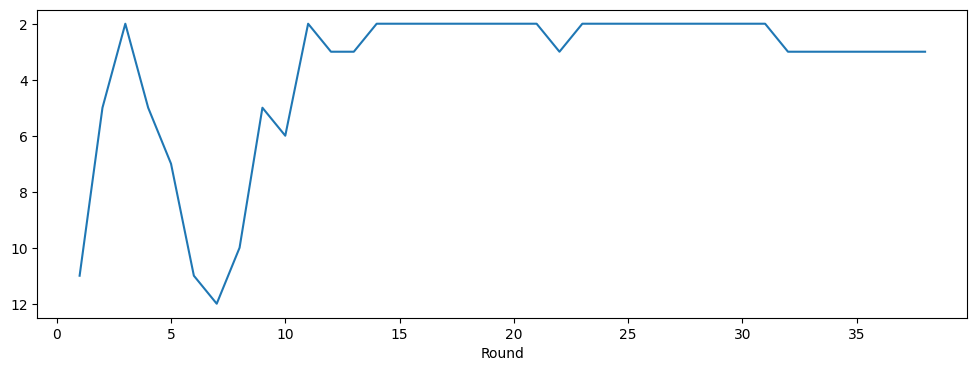

In [ ]:
team_performance_plot('Juventus', 2009)

In [ ]:
# check the relation between 2 given teams
def teams_check(teams):
    divisions = []
    for team in teams:
        try:
            matches.query('HomeTeam == @team').iloc[0]['Div']
        except IndexError:
            return False # team's name isn't occur in dataset
        else:
            division = matches.query('HomeTeam == @team').iloc[0]['Div']
            divisions.append(division)
    # if 2 teams are in the same league, return True
    if len(set(divisions)) > 1:
        return False
    else:
        return True

In [ ]:
# compare ranking variations of teams in the same league
def team_performance_compare(teams, season):
    check = teams_check(teams)
    if not check:
        msg = 'Choose Other Teams!'
        return msg
    else:
        sample = teams[0]
        division = matches.query('HomeTeam == @sample').iloc[0]['Div']
        maxround = max_round(division, season)
        # query values
        ranks = []
        for i in range(maxround):
            round = i + 1
            try:
                x = league_result_after_round(division, season, round).loc[teams]['Rank'].to_list()
            except KeyError:
                return 'Choose Another Season!'
            else:
                rank = league_result_after_round(division, season, round).loc[teams]['Rank'].to_list()
            ranks.append(rank)
        ranks = np.array(ranks)
        # collect data
        data = {'Round': list(range(maxround))}
        for i in range(len(teams)):
            data[f'{teams[i]}'] = ranks[:, i]
        # edit frame
        frame = pd.DataFrame(data)
        frame['Round'] += 1
        frame.sort_values(by=['Round'], inplace=True)
        frame.set_index('Round', inplace=True)
        return frame

In [ ]:
# plot the right above function
def team_performance_compare_plot(team, season):
    frame = team_performance_compare(team, season)
    if isinstance(frame, str):
        return 'Choose Other Teams or Season!'
    else:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax = sns.lineplot(frame)
        ax.invert_yaxis()
        plt.show()

In [ ]:
# test
team_performance_compare(['Barcelona', 'Real Madrid', 'Sevilla'], 2010)

,Barcelona,Real Madrid,Sevilla
Round,,,
1,3,7,17
2,1,3,7
3,2,1,6
4,2,1,3
5,2,1,3
6,1,2,3
7,1,2,3
8,1,2,3
9,1,2,3


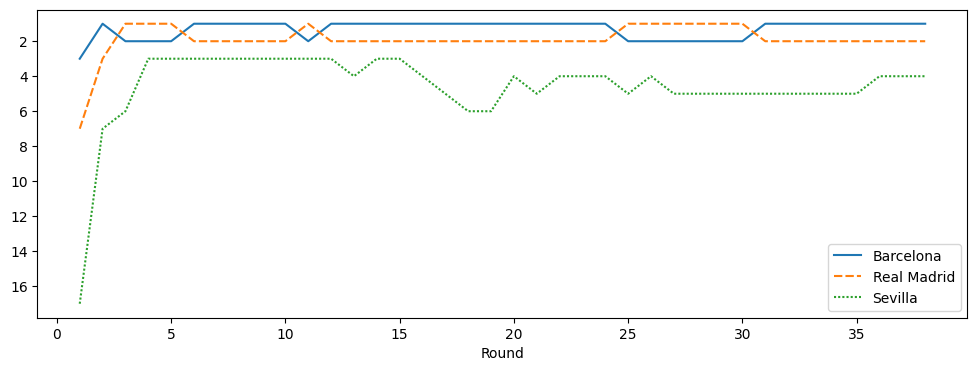

In [ ]:
team_performance_compare_plot(['Barcelona', 'Real Madrid', 'Sevilla'], 2010)

Head-to-head report

In [ ]:
# head-to-head statistics between 2 given teams
def head_to_head(team_1, team_2):
    # check division
    df1 = matches.query('HomeTeam == @team_1 and AwayTeam == @team_2')
    if df1.shape[0] == 0:
        msg = 'Choose Another Team!'
        return msg
    else:
        # create data sheet
        stats = ['Matches', 'Won', 'Drawn', 'Goals', 'Clean Sheets']
        team_1_stats = [0] * 5
        team_2_stats = [0] * 5
        # get related records
        df2 = matches.query('HomeTeam == @team_2 and AwayTeam == @team_1')
        # fill the sheet
        # Matches
        num = df1.shape[0] +  df2.shape[0]
        team_1_stats[0] = num
        team_2_stats[0] = num
        #results
        team_1_stats[1] = df1.query('FTR == "H"').shape[0] + df2.query('FTR == "A"').shape[0]
        team_1_stats[2] = df1.query('FTR == "D"').shape[0] + df2.query('FTR == "D"').shape[0]
        team_2_stats[2] = team_1_stats[2]
        team_2_stats[1] = team_2_stats[0] - team_2_stats[2] - team_1_stats[1]
        # goals
        team_1_stats[3] = df1['FTHG'].sum() + df2['FTAG'].sum()
        team_2_stats[3] = df1['FTAG'].sum() + df2['FTHG'].sum()
        # clean sheets
        team_1_stats[4] = df1.query('FTAG == 0').shape[0] + df2.query('FTHG == 0').shape[0]
        team_2_stats[4] = df1.query('FTHG == 0').shape[0] + df2.query('FTAG == 0').shape[0]
        # edit out
        data = {'stats': stats, f'{team_1}': team_1_stats, f'{team_2}': team_2_stats}
        frame = pd.DataFrame(data)
        frame = frame.iloc[:, [1, 0, 2]]
        return frame

In [ ]:
# test
head_to_head('Inter', 'Milan')

,Inter,stats,Milan
0,32.0,Matches,32.0
1,18.0,Won,8.0
2,6.0,Drawn,6.0
3,51.0,Goals,36.0
4,11.0,Clean Sheets,8.0


Export tables to csv files

In [ ]:
path = '/content/drive/My Drive/MyFolder/'
divisons_name = 'cleaned_divisions.csv'
matches_name = 'cleaned_matches.csv'
div_season_match_team_name = 'cleaned_relation.csv'

with open(path+divisons_name, 'w') as f:
    divisions.to_csv(f, index=False)

with open(path+matches_name, 'w') as f:
    matches.to_csv(f, index=False)

with open(path+div_season_match_team_name, 'w') as f:
    div_season_match_team.to_csv(f)

In [ ]:
# export all results
seasons = range(2006, 2022)

division = 'E0'
results = []
for season in seasons:
    maxround = max_round(division, season)
    for round in range(1, maxround+1):
        frame = league_result_after_round(division, season, round)
        frame['Round'] = round
        frame['Season'] = season
        results.append(frame)
E0_results = pd.concat(results)
E0_results['Div'] = 'E0'
E0_results.reset_index(drop=False, inplace=True)

In [ ]:
division = 'D1'
results = []
for season in seasons:
    maxround = max_round(division, season)
    for round in range(1, maxround+1):
        frame = league_result_after_round(division, season, round)
        frame['Round'] = round
        frame['Season'] = season
        results.append(frame)
D1_results = pd.concat(results)
D1_results['Div'] = 'D1'
D1_results.reset_index(drop=False, inplace=True)

In [ ]:
division = 'F1'
results = []
for season in seasons:
    maxround = max_round(division, season)
    for round in range(1, maxround+1):
        frame = league_result_after_round(division, season, round)
        frame['Round'] = round
        frame['Season'] = season
        results.append(frame)
F1_results = pd.concat(results)
F1_results['Div'] = 'F1'
F1_results.reset_index(drop=False, inplace=True)

In [ ]:
division = 'I1'
results = []
for season in seasons:
    maxround = max_round(division, season)
    for round in range(1, maxround+1):
        frame = league_result_after_round(division, season, round)
        frame['Round'] = round
        frame['Season'] = season
        results.append(frame)
I1_results = pd.concat(results)
I1_results['Div'] = 'I1'
I1_results.reset_index(drop=False, inplace=True)

In [ ]:
division = 'N1'
results = []
for season in seasons:
    maxround = max_round(division, season)
    for round in range(1, maxround+1):
        frame = league_result_after_round(division, season, round)
        frame['Round'] = round
        frame['Season'] = season
        results.append(frame)
N1_results = pd.concat(results)
N1_results['Div'] = 'N1'
N1_results.reset_index(drop=False, inplace=True)

In [ ]:
division = 'SP1'
results = []
for season in seasons:
    maxround = max_round(division, season)
    for round in range(1, maxround+1):
        frame = league_result_after_round(division, season, round)
        frame['Round'] = round
        frame['Season'] = season
        results.append(frame)
SP1_results = pd.concat(results)
SP1_results['Div'] = 'SP1'
SP1_results.reset_index(drop=False, inplace=True)

In [ ]:
all_results = pd.concat([D1_results, E0_results, F1_results, I1_results, N1_results, SP1_results], ignore_index=True)

In [ ]:
path = '/content/drive/My Drive/MyFolder/'
all_results_name = 'all_results.csv'

with open(path+all_results_name, 'w') as f:
    all_results.to_csv(f, index=False)